In [ ]:
import tensorflow as tf # tensorflow 2.10
import numpy as np
import matplotlib.pyplot as plt
from load_data2 import evals_parser, evals_square_parser, evecs_parser

In [ ]:
# Importing the datasets
batch_size = 16
tfile = "/home/gaspard/ETHZ/Master_Arbeit/acoupipe_datasets/training_1-100000_csmtriu_1src_he4.0625-1393.4375Hz_ds1-v001_13-Sep-2022.tfrecord"
"""
dataset = tf.data.TFRecordDataset(filenames=[tfile])

evals_dataset = dataset.map(evals_parser)
evals_dataset = evals_dataset.shuffle(buffer_size=10).batch(batch_size)

evals_square_dataset = dataset.map(evals_square_parser)
evals_square_dataset = evals_square_dataset.shuffle(buffer_size=10).batch(batch_size)

evecs_dataset = dataset.map(evecs_parser)
evecs_dataset = evecs_dataset.shuffle(buffer_size=10).batch(batch_size)
"""

### WGANGP to generate eigenvalues

In [ ]:
from evals_WGANGP2 import evals_WGANGP

# Creating GAN
evals_wgangp = evals_WGANGP()

In [ ]:
evals_wgangp.train(n_epoch=3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

is_real, sample = evals_wgangp.generate_evals()
sample = np.sort(np.array(sample[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
sample_dB = 10*np.log10(sample)


if is_real:
    plt.title("generated sample, detected as real")
    plt.plot(sample_dB)
else:
    plt.title("generated sample, detected as fake")
    plt.plot(sample_dB)    

### WGANGP to generate eigenvectors

In [ ]:
from evecs_WGANGP2 import evecs_WGANGP

# Creating GAN
evecs_wgangp = evecs_WGANGP()

In [ ]:
evecs_wgangp.train(n_epoch=2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

is_real, sample = evecs_wgangp.generate_evecs()
print(sample.shape)

sample_real = sample[0, :, :, 0] # get real part from sample
sample_imag = sample[0, :, :, 1] # get imaginary part from sample

if is_real:

    fig = plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title("Real part")
    plt.imshow(sample_real)

    plt.subplot(1,2,2)
    plt.title("Imaginary part")
    plt.imshow(sample_imag)

    fig.suptitle('Sample detect as real', fontsize=16)

    
else:
    fig = plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title("Real part")
    plt.imshow(sample_real)

    plt.subplot(1,2,2)
    plt.title("Imaginary part")
    plt.imshow(sample_imag)

    fig.suptitle('Sample detect as fake', fontsize=16)


### Check validity of obtained data

- Use both WGAN-GPs to generate eigenvalues and eigenvectors
- Use the eigendecomposition formula to recreate (scaled) CSM
- Use obtained CSM to perform beamforming

In [ ]:
from beamforming import beamform, get_csm

evals_are_real, generated_evals = evals_wgangp.generate_evals()
evecs_are_real, generated_evecs = evecs_wgangp.generate_evecs()

#if evals_are_real and evecs_are_real:
    
# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = generated_evecs[0, :, :, 0] # get real part from sample
evecs_imag = generated_evecs[0, :, :, 1] # get imaginary part from sample

print("-=-=-=-=-=-=-=-=-=-=-=-=-")
print(f"real_evecs_real.shape={evecs_real.shape}")
print(f"real_evecs_imag.shape={evecs_imag.shape}")
print(f"tmp_evals_vec.shape={evals_vec.shape}")
print("-=-=-=-=-=-=-=-=-=-=-=-=-")


csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

#print(dir(csm))

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64
    

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)



### Data Augmentation 

2022-10-24 15:08:55.404695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 15:08:55.603418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 15:08:55.603445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-24 15:08:55.642976: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-24 15:08:56.710490: W tensorflow/stream_executor/platform/de

-=-=- EPOCH 1 -=-=-
>loss: [c=8.460][g=0.377]
>accuracy: [c=0.500][g=0.688]

-=-=- EPOCH 2 -=-=-
>loss: [c=0.690][g=0.923]
>accuracy: [c=0.500][g=0.688]

-=-=- EPOCH 3 -=-=-
>loss: [c=0.325][g=0.595]
>accuracy: [c=0.500][g=0.688]

-=-=- EPOCH 4 -=-=-
>loss: [c=3.410][g=0.884]
>accuracy: [c=0.500][g=0.938]

-=-=- EPOCH 5 -=-=-
>loss: [c=22.390][g=0.920]
>accuracy: [c=0.500][g=0.938]

-=-=- EPOCH 6 -=-=-
>loss: [c=2.390][g=0.403]
>accuracy: [c=0.500][g=0.688]

-=-=- EPOCH 7 -=-=-
>loss: [c=15.405][g=0.595]
>accuracy: [c=0.500][g=0.688]

-=-=- EPOCH 8 -=-=-
>loss: [c=5.093][g=0.421]
>accuracy: [c=0.500][g=0.688]

-=-=- EPOCH 9 -=-=-
>loss: [c=0.661][g=0.516]
>accuracy: [c=0.500][g=0.562]

-=-=- EPOCH 10 -=-=-
>loss: [c=-0.170][g=0.741]
>accuracy: [c=0.500][g=0.750]

-=-=- EPOCH 11 -=-=-
>loss: [c=1.962][g=0.573]
>accuracy: [c=0.500][g=0.750]

-=-=- EPOCH 12 -=-=-
>loss: [c=1.005][g=0.744]
>accuracy: [c=0.500][g=0.688]

-=-=- EPOCH 13 -=-=-
>loss: [c=2.303][g=1.027]
>accuracy: [c=0.500][g=

[array([[[ 0.02514178+0.0000000e+00j, -0.01722215+1.1503989e-02j,
           0.01173194+1.0128649e-02j, ..., -0.00359384+1.9322064e-02j,
           0.01793369+1.4424660e-02j,  0.01296139-1.4489779e-02j],
         [-0.01722215-1.1503990e-02j,  0.02265606-4.6566129e-10j,
          -0.00032737-2.1456223e-02j, ...,  0.01311842-1.9293942e-02j,
          -0.01110191-1.9663015e-02j, -0.01245412+1.3351516e-02j],
         [ 0.01173194-1.0128648e-02j, -0.00032737+2.1456223e-02j,
           0.02369572+9.3132257e-10j, ...,  0.0107918 +1.1211032e-02j,
           0.01561909-8.2795043e-04j, -0.00946534-1.4203249e-02j],
         ...,
         [-0.00359384-1.9322064e-02j,  0.01311842+1.9293942e-02j,
           0.0107918 -1.1211031e-02j, ...,  0.03747204+0.0000000e+00j,
           0.00843801-2.0530475e-02j, -0.01760893-2.4640872e-03j],
         [ 0.01793369-1.4424660e-02j, -0.01110191+1.9663015e-02j,
           0.01561909+8.2795043e-04j, ...,  0.00843801+2.0530475e-02j,
           0.04257593+0.0000000e+

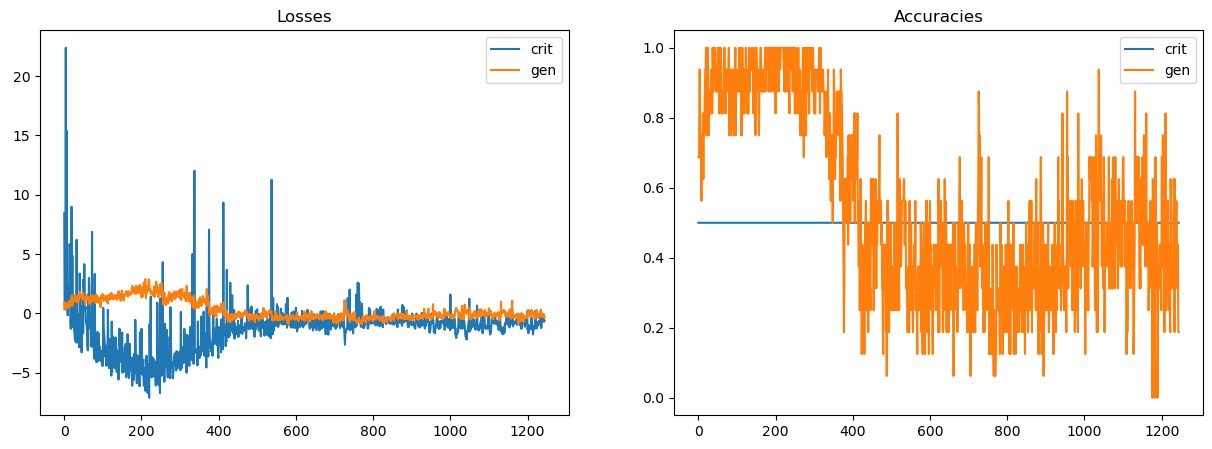

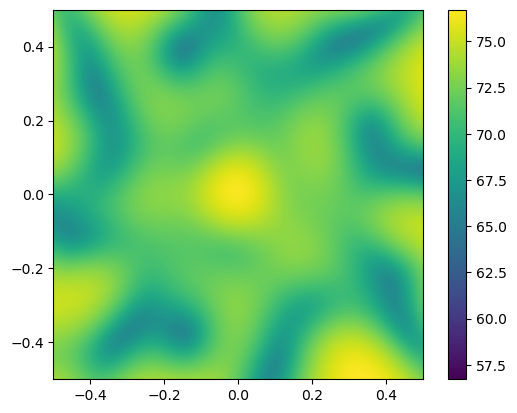

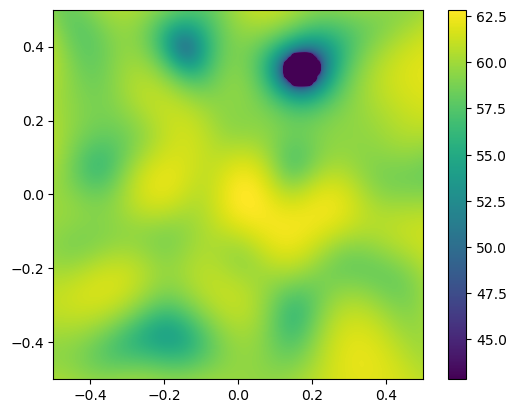

In [1]:
from data_augmentation import get_augmentented_dataset

get_augmentented_dataset(n_epoch=1245, size_augmentation=3, size_original_datasets=10)

### GRIDSEARCH: GAN to generate eigenvalues

In [ ]:
from tensorflow import summary
from evals_GAN2 import evals_GAN

lr_list = [5e-7, 1e-7, 5e-8, 1e-8, 5e-9, 1e-9]
#lr_list = [1e-10, 1e-11, 1e-12]
beta_1_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

for lr in lr_list:
    for beta_1 in beta_1_list:
        
        print(f"lr={lr}, beta_1={beta_1}")
        
        evals_gan = evals_GAN(lr, beta_1, summary=False) # Creating GAN
        evals_gan.train(evals_dataset=evals_dataset, n_epoch=500, print_epoch=False) # Training the GAN

        # Plotting sampled eigenvalues 
        is_real, sample = evals_gan.get_evals()
        
        fig = plt.figure()

        if is_real:
            plt.title(f"generated sample, detected as real, lr={lr}, b={beta_1}")
            plt.plot(np.sort(np.array(sample)[0]))
        else:
            plt.title(f"generated sample, detected as fake, lr={lr}, b={beta_1}")
            plt.plot(np.sort(np.array(sample)[0]))

In [ ]:
# Grid search 2
#from tensorflow import summary
from evals_GAN2 import evals_GAN

lr_list = [1e-9, 1e-9, 1e-8, 1e-7, 1e-7]
beta_1_list = [0.5, 0.7, 0.2, 0.1, 0.9]

n_epoch=250

for lr, beta_1 in zip(lr_list, beta_1_list):
    
    print(f"lr={lr}, beta_1={beta_1}")
    
    evals_gan = evals_GAN(lr, beta_1, summary=False) # Creating GAN
    evals_gan.train(evals_dataset=evals_dataset, n_epoch=n_epoch, print_epoch=False) # Training the GAN

    # Plotting sampled eigenvalues 
    is_real, sample = evals_gan.get_evals()
    
    fig = plt.figure()

    if is_real:
        plt.title(f"generated sample, detected as real, lr={lr}, b={beta_1}")
        plt.plot(np.sort(np.array(sample)[0]))
    else:
        plt.title(f"generated sample, detected as fake, lr={lr}, b={beta_1}")
        plt.plot(np.sort(np.array(sample)[0]))
    
# runtime   : 1000 epochs  : approx 5min30
# runtime   : 250 epochs   : approx 1min30

### GAN to generate eigenvalues

In [ ]:
from evals_GAN2 import evals_GAN

# Creating GAN
evals_gan = evals_GAN()

# Training the GAN
evals_gan.train(evals_dataset=evals_dataset, n_epoch=100)

In [ ]:
# Plotting sampled eigenvalues 
is_real, sample = evals_gan.get_evals()

if is_real:
    plt.title("generated sample, detected as real")
    plt.plot(np.sort(np.array(sample)[0]))
else:
    plt.title("generated sample, detected as fake")
    plt.plot(np.sort(np.array(sample)[0]))

### DCGAN to generate eigenvalues

In [ ]:
from evals_DCGAN2 import evals_DCGAN

# Creating GAN
evals_dcgan = evals_DCGAN()

# Training the GAN
evals_dcgan.train(evals_dataset=evals_dataset, n_epoch=300)

In [ ]:
# Plotting sampled eigenvalues 
is_real, sample = evals_dcgan.get_evals()

if is_real:
    plt.title("generated sample, detected as real")
    plt.plot(np.sort(np.array(sample)[0]))
else:
    plt.title("generated sample, detected as fake")
    plt.plot(np.sort(np.array(sample)[0]))

### WGAN to generate eigenvectors 

In [ ]:
from evecs_WGAN2 import evecs_WGAN

# Creating WGAN
evecs_wgan = evecs_WGAN()

In [ ]:
evecs_wgan.train(evecs_dataset=evecs_dataset, n_epoch=1000)

In [ ]:
sample = evecs_wgan.get_evecs()